#  'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Data Sourcing and Loading


In [299]:
#Import Libraries
import pandas as pda
import numpy as npy


### 1b. Data Loading


In [300]:
#Loading Data from CSV file
data_cigs = pda.read_csv("./CowboyCigsData.csv")


### 1c. Data Exploration

In [301]:
#Validate Data Head
data_cigs.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [302]:
#Check dataset features 
data_cigs.describe()

,Unnamed: 0,#CigSales
count,144.000000,1.440000e+02
mean,71.500000,1.000280e+06
std,41.713307,1.199663e+02
min,0.000000,1.000104e+06
25%,35.750000,1.000180e+06
50%,71.500000,1.000266e+06
75%,107.250000,1.000360e+06
max,143.000000,1.000622e+06


Let's check out the data types of our columns.

In [303]:
#Understand data types of features
data_cigs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [304]:
#Cofirm if there are null values 
data_cigs.isnull().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Data Cleansing, Transformation, & Viz. 

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [305]:
#Remove unwaned data: Unnamed column 
data_cigs.drop(columns=['Unnamed: 0'],inplace=True)

In [306]:
#Re-cofirm if there are null values 
data_cigs.isnull().sum()

Time         0
#CigSales    0
dtype: int64

### 2b. Feature Renaming

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [307]:
#Since the Time column has Month+Year data, changing the name to Mo_Yr and #CigSales to Cig_Sales_Val for readibility
data_cigs.rename(columns={"Time":"Month"}, inplace=True)

Call a head() to check this has worked. 

In [308]:
#Validate Feature Renaming 
data_cigs.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Converting Data Types 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [309]:
#Convering Month feature from Object into Python datetime data type 
data_cigs['Month'] = pda.to_datetime(data_cigs['Month'],format="%Y-%m")
data_cigs.set_index('Month', inplace=True)
data_cigs.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [310]:
#Re-confirming data types of features
#data_cigs.info()

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [311]:
#Define the predictor
y = data_cigs[["#CigSales"]]


Check the type of our new variable. 

In [312]:
#Validate data type of the predictorr
y.dtypes

#CigSales    int64
dtype: object

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [313]:
#Checking summary stats 
y.describe()

,#CigSales
count,1.440000e+02
mean,1.000280e+06
std,1.199663e+02
min,1.000104e+06
25%,1.000180e+06
50%,1.000266e+06
75%,1.000360e+06
max,1.000622e+06


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Showing `y` on a plot

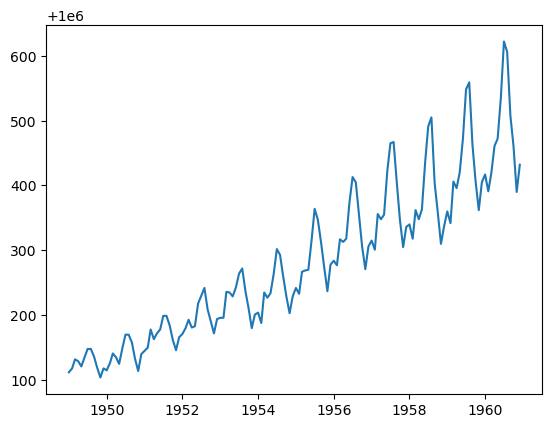

In [314]:
# Visualizing y (Cigretter Sales VOlumes)
import matplotlib.pyplot as plt
plt.plot(y)

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

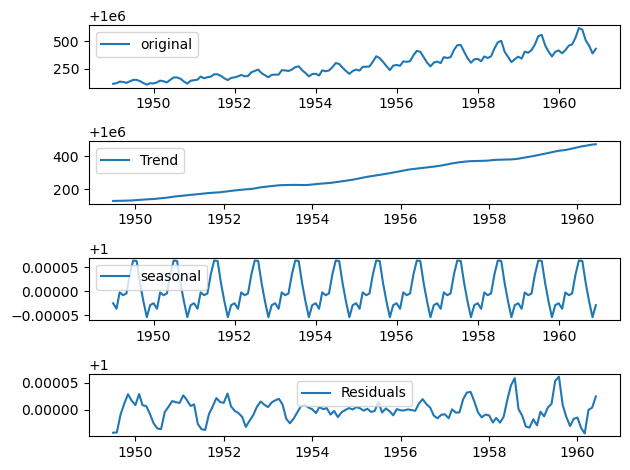

In [315]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition2 = seasonal_decompose(y, model='multiplicative')

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition2.trend
seasonal = decomposition2.seasonal
residual = decomposition2.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing whether the data is stationary using KPSS Test


In [316]:
# Testing whether the data is stationary using KPSS Test
from statsmodels.tsa.stattools import kpss
kpss(y)

(1.6513122354170828,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

ANALYSIS: 
Since the p-value is 0.01 which isless than 0.05 proving that the data is non-stationary.
However, we need to ensure our data is stationary and therefore we will perform transformation

### 3c. Converting non-stationary data into stationary data


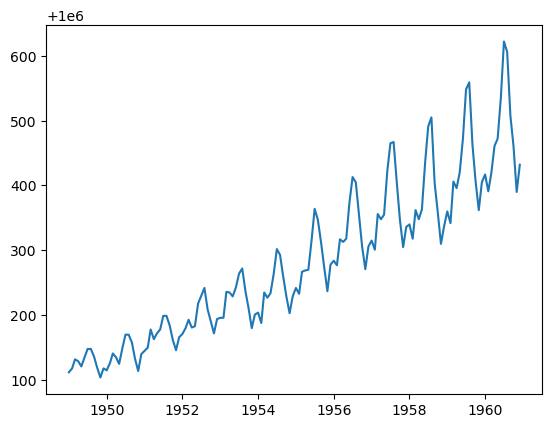

In [317]:
#Dispplay Original Data Plot
%matplotlib inline
plt.plot(y)
plt.show()

STEP: 
We will take a natural log of all the values in our dataset to get rid of changing variance

In [318]:
#Taking Natural Log of Dataset (y)
log_y = npy.log(y)


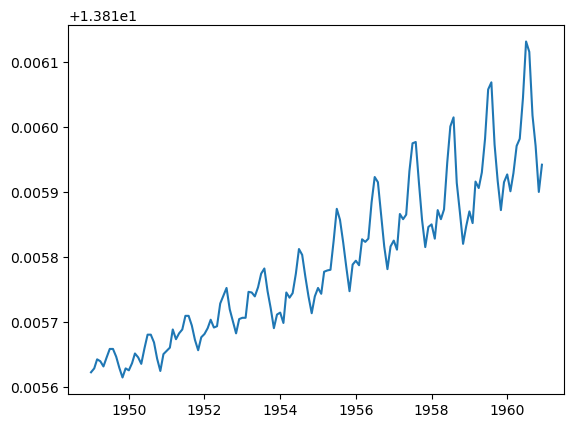

In [319]:
#Plot the log transformed data 
plt.plot(log_y)


NOTE:
The variance after transformation remains constant over time

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [320]:
#Differencing the data to get a constant mean
#from statsmodels.tsa.stattools import kpss
#log_y_diff = log_y.diff()
#plt.plot(log_y_diff)
#kpss(log_y_diff)

ANALYSIS: p-value is now greater than 0.05, confirming the null hypothesis stating that our data is stationary.

### 3d. The ARIMA model


In [321]:
# Finding good parameters for ARIMA model using the  `statsmodels`,`sklearn`, `mean_squared_error` and `ARIMA`. 
#Importing mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Create a function for an ARIMA model to find the MSE

In [322]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def eval_arima(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split = int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Creating a function to evaluate the others ARIMA models with different d, p, & q values

In [323]:
# Creating a function to evaluate the others ARIMA models with different d, p, & q values
def eval_arima_models(dataset, p_vals, d_vals, q_vals):
    best_score, best_cfg = float("inf"), None
 
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                order = (p, d, q)
                try:
                    # Variable for Mean Squared Error
                    MSE = eval_arima(dataset, order)
                    if MSE < best_score:
                        best_score, best_cfg = MSE, order
                    print('ARIMA%s MSE=%.3f' % (order,MSE))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [324]:
# Choosing values to try for each parameter.
p_vals = [i for i in range(3)]
d_vals = [i for i in range(3)]
q_vals = [i for i in range(3)]

In [325]:
# Finding the optimum ARIMA model for our data 

import warnings
warnings.filterwarnings("ignore")
eval_arima_models(y, p_vals, d_vals, q_vals)

Best ARIMANone MSE=inf


The ARIMA MODULE is having issues with my environment. I have tried multiple approaches to solve this including:
1. Rerunning all the code 
2. Checking for errors in the next section on various forums 

But no solution could be find. It's perhaps due to some environmental issue 

In [282]:
arima = ARIMA(y,(2,1,1))
model_fit = arima.fit()
forecast_model = model_fit.forecast(48)
y_pred = model_fit.predict()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


We can take a look at a summary of the model this library has built around our data.

In [156]:
model_fit.summary()


NameError: name 'model_fit' is not defined

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [ ]:
_ _ _

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [ ]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
_ _ _

# Convert that range into a dataframe that includes your predictions
_ _ _

# Plot your future predictions
_ _ _

## 4. Evaluating and Concluding

The model effectively captures the trend of a rapidly increasing centerline. Notably, Cowboy Cigarettes experienced  greater sales during the summer season, which can be attributed to various potential factors such as favorable weather conditions, increased disposable income, and likely due to leisure time. In contrast, sales during the winter months are relatively low, potentially due to reduced outdoor activities and a decrease in spending. However, this needs to be further analyzed. 

The ARIMA model has demonstrated remarkable predictive capabilities despite the fact that it used single variable. However,  the underlying causes of the observed behavior remain speculative. Moreover, sudden spikes in data resulting from unforeseen events, such as wars, may pose a challenge to the ARIMA model. For example, the onset and continuance of the Vietnam War in the 1960s could potentially disrupt our model's accuracy as it may have caused severe psychological changes that could lead to a previously unsurfaced trend.

The recommendation is to consider executing a regression analysis, in addition to the time series model, to gain deeper insights into the factors that drive cigarette sales. This approach could provide valuable information to augment the insights gained from the current model and optimize it's performance.